In [68]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone

rawx_file = '/Users/dorsic/Development/github/u-blox/GEN9/data/pseudorange-59828.txt'
clock_file = '/Users/dorsic/Development/github/u-blox/GEN9/data/clock-59828.txt'
rinex_file = '/Users/dorsic/Development/github/u-blox/GEN9/data/pseudorange-59828-2h.rno'
signals = ['G1C', 'B1D', 'R1C', 'E1C', 'B1X', 'E7Q', 'B5D', 'B7D', 'G2L', 'R2C']

leapSec = 0
#G   12 C1C L1C D1C S1C C2L L2L D2L S2L C2S L2S D2S S2S      SYS / # / OBS TYPES
#R    8 C1C L1C D1C S1C C2C L2C D2C S2C                      SYS / # / OBS TYPES
#E    8 C1C L1C D1C S1C C7Q L7Q D7Q S7Q                      SYS / # / OBS TYPES
#C    8 C2I L2I D2I S2I C7I L7I D7I S7I                      SYS / # / OBS TYPES
#J   12 C1C L1C D1C S1C C2S L2S D2S S2S C2L L2L D2L S2L      SYS / # / OBS TYPES


#GPS L1 C/A - C1C L1C D1C S1C # pseudorange, carierphase, doppler, signal strength
#GPS L2C(L) - C2L L2L D2L S2L
#GPS L2C(M) - C2S L2S D2S S2S

#Galileo E1B/C - C1C L1C D1C S1C
#Galileo E5b - C7Q L7Q D7Q S7Q 
#Beidou B1I - C2I L2I D2I S2I
#Beidou B2I - C7I L7I D7I S7I 
#Glonass L1OF - C4A L4A D4A S4A
#Glonass L2OF - C6B L6B D6B S6B

#• GPS:L1C/A,L2C
#• GLONASS:L1OF,L2OF
#• Galileo:E1B/C,E5b
#• BeiDou:B1I,B2I
#• QZSS:L1C/A,L2C

In [69]:
df = pd.read_csv(rawx_file, sep='\t')
df['DATE'] = pd.to_datetime(df.TS+leapSec, utc=True, unit='s')
df.sort_values(by=['TS', 'SAT', 'SIG'], inplace=True)
dfc = pd.read_csv(clock_file, sep='\t')
df.head(5)

,LCL,TS,MJD,SAT,SIG,PSEUDORANGE,CARRIERPHASE,DOPPLER,CNO,PRSTD,...,LOCKTIME,PRVALID,CPVALID,HALFCYC,SUBHALFCYC,LEAPS,LEAPSEC,CLKRESET,RESERVED1,DATE
5,1.662422e+09,1.662422e+09,59828.000003,C05,B1X,3.775324e+07,1.965911e+08,-573.100586,40,4,...,64500,1,1,1,0,18,1,0,2468865,2022-09-06 00:00:17.993999872+00:00
31,1.662422e+09,1.662422e+09,59828.000003,C05,B7D,3.775323e+07,1.520166e+08,-443.664307,31,6,...,260,1,1,0,0,18,1,0,2468865,2022-09-06 00:00:17.993999872+00:00
14,1.662422e+09,1.662422e+09,59828.000003,C13,B1D,3.751123e+07,1.953308e+08,1108.716064,14,9,...,0,1,0,0,0,18,1,0,2468865,2022-09-06 00:00:17.993999872+00:00
6,1.662422e+09,1.662422e+09,59828.000003,C29,B1D,2.178856e+07,1.134588e+08,2214.061768,44,3,...,64500,1,1,1,0,18,1,0,2468865,2022-09-06 00:00:17.993999872+00:00
7,1.662422e+09,1.662422e+09,59828.000003,C30,B1D,2.015172e+07,1.049352e+08,-815.112793,46,3,...,64500,1,1,1,1,18,1,0,2468865,2022-09-06 00:00:17.993999872+00:00


In [74]:
def writetime(timestamp:datetime, numsatellites, rcv_clock_offset) -> None:
    sec = timestamp.second
    msec = timestamp.microsecond * 1e-3
    msec = int(round(msec) * 1e4)
    return "".join(["> ", timestamp.strftime("%Y %m %d %H %M"), " ", f"{sec:2}.{msec:07}", "  0", f"{numsatellites:3}", f"{'':6}", "%15.12f"%rcv_clock_offset])

def writesat(sat:str, 
        f1_pseudorange:float=0.0, f1_carrierphase:float=0.0, f1_doppler:float=0.0, f1_strength:float=0.0, f1_lli:int=0,
        f2_pseudorange:float=0.0, f2_carrierphase:float=0.0, f2_doppler:float=0.0, f2_strength:float=0.0, f2_lli:int=0) -> None:
    return "".join(["%3s"%sat,
                    "%14.3f"%f1_pseudorange, "  ", "%14.3f"%f1_carrierphase, "%1i"%f1_lli, " ", "%14.3f"%f1_doppler, "  ", "%14.3f"%f1_strength, "  ",
                    "%14.3f"%f2_pseudorange, "  ", "%14.3f"%f2_carrierphase, "%1i"%f2_lli, " ", "%14.3f"%f2_doppler, "  ", "%14.3f"%f2_strength, "  "
                    ]).replace(' 0.0001', '       ').replace(' 0.000', '      ')

# sigs is array of dicts
def writesatsigs(sat:str, currentsignals:dict[str, dict], lastvisible:dict[str,dict], dualonly=False, phaseonly=False) -> str:
    #print(lastseen['sat']['sat'], [sig['sig'] for sig in sigs])
    if not sat:
        return
    measurement = {'f1_pseudorange': 0.0, 'f1_carrierphase': 0.0, 'f1_doppler': 0.0, 'f1_cno': 0.0, 'f1_lli': 1,
                    'f2_pseudorange': 0.0, 'f2_carrierphase': 0.0, 'f2_doppler': 0.0, 'f2_cno': 0.0, 'f2_lli': 1,}
    for sig in currentsignals:
        siglastvisiblelocktime = lastvisible[sig].LOCKTIME if sig in lastvisible else -1
        f = 'f1' if sig[1] in ['1'] else 'f2'
        measurement[f+'_pseudorange'] = currentsignals[sig].PSEUDORANGE if currentsignals[sig].PRVALID == 1 else 0.0
        measurement[f+'_carrierphase'] = currentsignals[sig].CARRIERPHASE if currentsignals[sig].CPVALID == 1 else 0.0
        measurement[f+'_doppler'] = currentsignals[sig].DOPPLER
        measurement[f+'_cno'] = currentsignals[sig].CNO
        lli = 1 if (currentsignals[sig].LOCKTIME - siglastvisiblelocktime) < 0 else 0
        measurement[f+'_lli'] = lli
    if (dualonly and (measurement['f1_pseudorange'] == 0.0 or measurement['f2_pseudorange'] == 0.0)):
        return None
    if (phaseonly and (measurement['f1_carrierphase'] == 0.0 or measurement['f2_carrierphase'] == 0.0)):
        return None
        
    return writesat(sat, measurement['f1_pseudorange'], measurement['f1_carrierphase'], measurement['f1_doppler'], measurement['f1_cno'], measurement['f1_lli'],
        measurement['f2_pseudorange'], measurement['f2_carrierphase'], measurement['f2_doppler'], measurement['f2_cno'], measurement['f2_lli'])


def writeepoch(outputfile, epochdata: dict):
    if ('measurements' not in epochdata) or len(epochdata['measurements']) == 0:
        return
    outputfile.write(writetime(epochdata['date'], len(epochdata['measurements']), epochdata['clock']) + '\n')
    for m in epochdata['measurements']:
        outputfile.write(m)


In [75]:
lastseen = {}
# stores current epoch processing data
# epoch - currently processing epoch
# sat - satellite data from last visible epoch
# signals - currently processing satellite PRN
processing = {'epoch': 0, 'sat': '', 'signals': {}}
dualonly = True
phaseonly = True
interval = 1        # export data every x seconds
rnf = open(rinex_file, 'w')
output = {'measurements':[]}
secs = -1
# the df rows has to be sorted by TS, SAT, SIG columns prior
for index, row in df.loc[((df.DATE.dt.second) % interval == 0)].iterrows():
#for index, row in df.loc[(df.DATE.dt.second % interval == 0) & (df.DATE.dt.hour == 16)].iterrows():
    if (processing['epoch'] != row.TS):
        writeepoch(rnf, output)
        #numsats = len(df.loc[df.TS == row.TS, 'SAT'].unique())
        clkbias = 0 #dfc.loc[dfc.TS == row.TS][0].CLKBIAS * 1.0e-9
        output = {'date': row.DATE, 'clock': clkbias, 'measurements': []}
        secs += interval
        if secs % 3600 == 0:
            print(secs)

    if (processing['sat'] == row.SAT and processing['epoch'] == row.TS):
        # store sat data to combine same satellite rows in each epoch
        processing['signals'][row.SIG] = row
    else:
        # a new satellite data comming in or new epoch (thus also new satellite data)
        lastvisible = lastseen[processing['sat']] if processing['sat'] in lastseen else []
        current = processing['signals']
        ln = None
        if (dualonly and len(current.keys()) > 1) or (not dualonly):
            ln = writesatsigs(processing['sat'], current, lastvisible, dualonly=dualonly, phaseonly=phaseonly)
        if (ln):
            output['measurements'].append(ln+'\n')
        # store sat data to calculate in between epochs
        lastseen[processing['sat']] = current
        processing = {'epoch': row.TS, 'sat': row.SAT, 'signals': {row.SIG: row}}

# dump last sat data
lastvisible = lastseen[processing['sat']] if processing['sat'] in lastseen else []
current = processing['signals']
ln = None
if (dualonly and len(current.keys()) > 1) or (not dualonly):
    ln = writesatsigs(processing['sat'], current, lastvisible, dualonly=dualonly, phaseonly=phaseonly)
if (ln):
    output['measurements'].append(ln+'\m')
writeepoch(rnf, output)

rnf.close()

0
3600
7200
10800
14400
18000
21600


In [55]:
ts, ns = [], []
with open(rinex_file, 'r') as f:
    for ln in f:
        if ln.startswith('>'):
            ts.append(ln[2:29])
            ns.append(ln[32:35])


<AxesSubplot:>

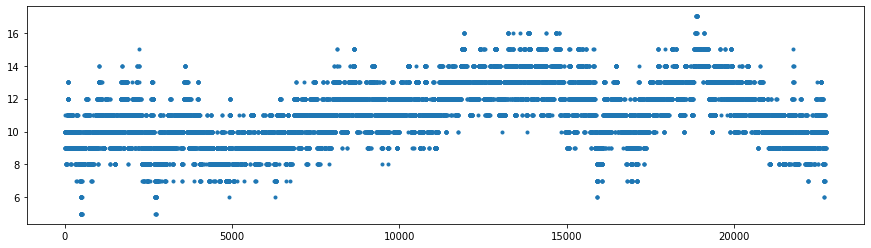

In [56]:
dfe = pd.DataFrame({'DATE': ts, 'NSAT': ns})
dfe['NSAT'] = dfe.NSAT.astype('int32')
dfe.NSAT.plot(figsize=(15,4), style='.')


In [22]:
dfm = pd.merge_asof(df, dfc, left_on='TS', right_on='TS', suffixes=['_psr', '_clk'], tolerance=0.4, direction='nearest')
dfm

,LCL_psr,TS,MJD_psr,SAT,SIG,PSEUDORANGE,CARRIERPHASE,DOPPLER,CNO,PRSTD,...,MJD_clk,CLKBIAS,CLKDRIFT,TACC,FACC,GPSACC,GALACC,BDSACC,GLOACC,UTCACC
0,1.660522e+09,1.660522e+09,59806.000003,B05,B1X,3.994303e+07,2.079939e+08,-542.034912,39,4,...,59806.0,608765.0,376.0,8.0,172.0,8.0,8.0,8.0,9.0,28.0
1,1.660522e+09,1.660522e+09,59806.000003,B05,B7D,3.994303e+07,1.608340e+08,-418.688965,40,4,...,59806.0,608765.0,376.0,8.0,172.0,8.0,8.0,8.0,9.0,28.0
2,1.660522e+09,1.660522e+09,59806.000003,B13,B5D,4.169364e+07,1.678830e+08,1274.125000,20,9,...,59806.0,608765.0,376.0,8.0,172.0,8.0,8.0,8.0,9.0,28.0
3,1.660522e+09,1.660522e+09,59806.000003,B26,B1D,2.495139e+07,1.299284e+08,2114.018555,22,9,...,59806.0,608765.0,376.0,8.0,172.0,8.0,8.0,8.0,9.0,28.0
4,1.660522e+09,1.660522e+09,59806.000003,B29,B1D,2.333981e+07,1.215365e+08,1683.369629,45,3,...,59806.0,608765.0,376.0,8.0,172.0,8.0,8.0,8.0,9.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063201,1.660599e+09,1.660599e+09,59806.891682,R03,R1C,1.791501e+07,9.590043e+07,2001.577759,18,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3063202,1.660599e+09,1.660599e+09,59806.891682,R11,R1C,1.873635e+07,1.001214e+08,-3872.036133,22,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3063203,1.660599e+09,1.660599e+09,59806.891682,R12,R1C,1.625023e+07,8.680573e+07,-853.161133,28,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3063204,1.660599e+09,1.660599e+09,59806.891682,R13,R1C,1.826501e+07,9.753411e+07,2153.148193,19,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
msec = 9950000
f"{msec:07}"


'9950000'